# Process the zscore results from the 5 diseases


For figure 2f

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

from IPython.display import display

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'sans-serif')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

% matplotlib inline


In [2]:
import sys
sys.path.append('/Users/brinrosenthal/Google Drive/UCSD/cluster_code/pyvenn-master/')
import venn

# Load the PCnet interactome


In [3]:
path_to_pcnet='/Users/brinrosenthal/Documents/CCBB_tickets_data/PCnet/G_PCnet.gpickle'
path_to_ASD_HC= '../../../data/ASD_HC.txt'
path_to_CHD_HC='../../../data/CHD_HC_new.txt'

In [4]:
Gint = nx.read_gpickle(path_to_pcnet)
print(len(Gint.nodes()))
print(len(Gint.edges()))

19781
2724724


# Load the seed genes

In [5]:
ASD_HC = pd.read_csv(path_to_ASD_HC,names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
print(len(ASD_HC))


CHD_HC = pd.read_csv(path_to_CHD_HC,names=['HC_genes'])
CHD_HC = CHD_HC['HC_genes'].tolist()
print(len(CHD_HC))

65
66


# Load the zscore data

In [6]:

num_reps=5000

# -------------- ASD and CHD results --------------
CHD_z = pd.read_csv('../../z_score_results/new_CHD_cohort/z_CHD_'+str(num_reps)+'_repsPCnet_degree_binning.tsv',sep='\t',names=['symbol','z'])
CHD_z.index=CHD_z['symbol']
CHD_z=CHD_z.sort_values('z',ascending=False)

ASD_z = pd.read_csv('../../z_score_results/new_CHD_cohort/z_ASD_'+str(num_reps)+'_repsPCnet_degree_binning.tsv',sep='\t',names=['symbol','z'])
ASD_z.index=ASD_z['symbol']
ASD_z=ASD_z.sort_values('z',ascending=False)



# -------------- DISGENET results --------------


print('\nAtherosclerosis:')
atherosclerosis_z = pd.read_csv('z_score_results/z_Atherosclerosis_5000_reps_degree_binning.tsv',sep='\t',names=['symbol','z'])
atherosclerosis_z.index=atherosclerosis_z['symbol']
atherosclerosis_z=atherosclerosis_z.sort_values('z',ascending=False)
# load seed genes and drop them
seed_genes_temp = pd.read_csv('Atherosclerosis_seed_genes_200420.tsv',sep='\t',index_col='Unnamed: 0')
seed_genes_temp = [str(g[1:-1]).strip("'") for g in seed_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]
print(len(seed_genes_temp))
print(len(atherosclerosis_z))
atherosclerosis_z=atherosclerosis_z.loc[list(np.setdiff1d(atherosclerosis_z.index.tolist(),seed_genes_temp))]
print(len(atherosclerosis_z))


print('\nKartagener syndrome:')
kartagena_z = pd.read_csv('z_score_results/z_Kartagener_5000_reps_degree_binning.tsv',sep='\t',names=['symbol','z'])
kartagena_z.index=kartagena_z['symbol']
kartagena_z=kartagena_z.sort_values('z',ascending=False)
# load seed genes and drop them
seed_genes_temp = pd.read_csv('Kartagener Syndrome_seed_genes_200420.tsv',sep='\t',index_col='Unnamed: 0')
seed_genes_temp = [str(g[1:-1]).strip("'") for g in seed_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]
print(len(seed_genes_temp))
print(len(kartagena_z))
kartagena_z=kartagena_z.loc[list(np.setdiff1d(kartagena_z.index.tolist(),seed_genes_temp))]
print(len(kartagena_z))


# -------------- ASD GWAS results ----------------
print('\nASD GWAS:')
ASD_GWAS_z = pd.read_csv('z_score_results/z_ASD_GWAS_PASCAL_PCnet_1000_reps_degree_binning.tsv',sep='\t',names=['symbol','z'])
ASD_GWAS_z.index=ASD_GWAS_z['symbol']
ASD_GWAS_z=ASD_GWAS_z.sort_values('z',ascending=False)
# load seed genes and drop them
# seed_genes_temp = pd.read_csv('Kartagener Syndrome_seed_genes_200420.tsv',sep='\t',index_col='Unnamed: 0')
# seed_genes_temp = [str(g[1:-1]).strip("'") for g in seed_genes_temp['seed_genes'].tolist()[0][1:-1].split(', ')]
# print(len(seed_genes_temp))
ASD_GWAS_z=ASD_GWAS_z.loc[list(np.setdiff1d(ASD_GWAS_z.index.tolist(),seed_genes_temp))]
print(len(ASD_GWAS_z))



Atherosclerosis:
65
19781
19716

Kartagener syndrome:
38
19781
19744

ASD GWAS:
19744


# How much do the networks overlap?

- Plot the gene overlap in subgraphs

In [7]:
# function to return significant digits in exp form
def nsf(num, n=1):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

def calculate_size_network_overlap(z1,z2,zthresh=3):
    z_merged = z1.join(z2['z'],lsuffix='_1',rsuffix='_2')
    z_combined = z_merged['z_1']*z_merged['z_2']*(z_merged['z_1']>0)*(z_merged['z_2']>0)
    high_z_genes = z_combined[z_combined>zthresh].index.tolist()
    
    return(len(high_z_genes))

def calculate_expected_overlap(d1,d2,z1,z2,plot=False,zthresh=4,numreps=1000):

    z_d1d2_size=calculate_size_network_overlap(z1,z2,zthresh=zthresh)

    high_z_rand = []
    for r in np.arange(numreps):
        # use permutation shuffling method instead of Fnew comparison
        d1_shuf_genes = z1.index.tolist()
        np.random.shuffle(d1_shuf_genes)
        d1_shuf=z1[:]
        d1_shuf.index=d1_shuf_genes

        d2_shuf_genes = z2.index.tolist()
        np.random.shuffle(d2_shuf_genes)
        d2_shuf=z2[:]
        d2_shuf.index=d2_shuf_genes

        high_z_temp = calculate_size_network_overlap(d1_shuf,d2_shuf,zthresh=zthresh)
        high_z_rand.append(high_z_temp)

    if plot==True:
        sns.distplot(high_z_rand,label='expected network intersection size')
        plt.plot([z_d1d2_size,z_d1d2_size],[0,0.015],label='observed '+d1+'-'+d2+' network intersection size')
        plt.xlabel('size of proximal subgraph, z>'+str(zthresh),fontsize=16)
        plt.legend(fontsize=12)
    return z_d1d2_size,high_z_rand

In [8]:
from scipy.stats import hypergeom
from scipy.stats import norm

z_dict = {'atherosclerosis':atherosclerosis_z,'kartagener':kartagena_z,
          'CHD':CHD_z,'ASD':ASD_z,'ASD_GWAS':ASD_GWAS_z}

# save the num overlap and overlap p-val in dataframes

focal_diseases = ['atherosclerosis','kartagener','CHD','ASD','ASD_GWAS']

network_num_overlap = pd.DataFrame(np.zeros((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_num_overlap.columns = focal_diseases

network_obs_exp = pd.DataFrame(np.zeros((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_obs_exp.columns = focal_diseases

network_pval_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_pval_overlap.columns = focal_diseases

network_exp_mean_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_exp_mean_overlap.columns = focal_diseases

network_exp_std_overlap = pd.DataFrame(np.ones((len(focal_diseases),len(focal_diseases))),index=focal_diseases)
network_exp_std_overlap.columns = focal_diseases


for i in np.arange(len(focal_diseases)-1):
    for j in np.arange(1+i,len(focal_diseases)):
        d1=focal_diseases[i]
        d2=focal_diseases[j]
        z1=z_dict[d1]
        z2=z_dict[d2]

        # replace hypergeometric with permutation empirical p
        z_d1d2_size,high_z_rand=calculate_expected_overlap(d1,d2,z1,z2,plot=False,numreps=100,zthresh=3)
        ztemp = (z_d1d2_size-np.mean(high_z_rand))/np.std(high_z_rand)
        ptemp = norm.sf(ztemp)
        print(d1+' + '+d2)
        print(z_d1d2_size)
        obs_exp_temp = float(z_d1d2_size)/np.mean(high_z_rand)
        print(obs_exp_temp)
        print(ptemp)
        
        
        network_num_overlap.loc[d1][d2]=z_d1d2_size
        network_num_overlap.loc[d2][d1]=z_d1d2_size

        network_pval_overlap.loc[d1][d2]=ptemp
        network_pval_overlap.loc[d2][d1]=ptemp
        
        network_obs_exp.loc[d1][d2]=obs_exp_temp
        network_obs_exp.loc[d2][d1]=obs_exp_temp
        
        network_exp_mean_overlap.loc[d1][d2]=np.mean(high_z_rand)
        network_exp_mean_overlap.loc[d2][d1]=np.mean(high_z_rand)
        
        network_exp_std_overlap.loc[d1][d2]=np.std(high_z_rand)
        network_exp_std_overlap.loc[d2][d1]=np.std(high_z_rand)
        
        

atherosclerosis + kartagener
134
0.37477275905467766
1.0
atherosclerosis + CHD
558
1.0498588899341486
0.08145142876465516
atherosclerosis + ASD
257
0.45091674708307744
1.0
atherosclerosis + ASD_GWAS
325
0.8312233049438604
0.999939760961408
kartagener + CHD
188
0.7521805233255981
0.9999957396666233
kartagener + ASD
290
1.061765459671219
0.11439394507246531
kartagener + ASD_GWAS
189
1.0060147974663332
0.4586120021993496
CHD + ASD
844
2.088591932689928
6.712773262559101e-132
CHD + ASD_GWAS
433
1.5425171885575861
2.662105151749607e-26
ASD + ASD_GWAS
487
1.5751342260172068
3.972111924589012e-33


In [10]:
# make sure significant overlaps have >0 overlapping genes
network_pval_overlap = np.minimum(network_pval_overlap*(network_num_overlap>0)+(network_pval_overlap+1)*(network_num_overlap==0),1)

display(network_num_overlap)
display(network_pval_overlap)

# network_num_overlap.to_csv('network_num_overlap_z'+str(zthresh)+'.tsv',sep='\t')
# (-np.log(network_pval_overlap)).to_csv('network_pval_overlap_z'+str(zthresh)+'_ATH_PSO_KART.tsv',sep='\t')

,psoriasis,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
psoriasis,0.0,1535.0,110.0,353.0,222.0,209.0
atherosclerosis,1535.0,0.0,134.0,558.0,257.0,325.0
kartagener,110.0,134.0,0.0,188.0,290.0,189.0
CHD,353.0,558.0,188.0,0.0,844.0,433.0
ASD,222.0,257.0,290.0,844.0,0.0,487.0
ASD_GWAS,209.0,325.0,189.0,433.0,487.0,0.0


,psoriasis,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
psoriasis,1.000000,0.000000,1.000000,9.293409e-01,1.000000e+00,9.999999e-01
atherosclerosis,0.000000,1.000000,1.000000,9.867158e-02,1.000000e+00,9.996657e-01
kartagener,1.000000,1.000000,1.000000,9.999907e-01,1.627816e-01,5.149310e-01
CHD,0.929341,0.098672,0.999991,1.000000e+00,2.880657e-138,3.802379e-24
ASD,1.000000,1.000000,0.162782,2.880657e-138,1.000000e+00,1.038226e-31
ASD_GWAS,1.000000,0.999666,0.514931,3.802379e-24,1.038226e-31,1.000000e+00


/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


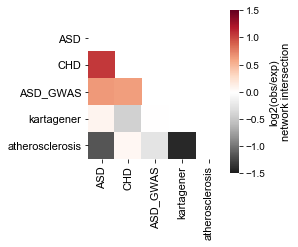

In [24]:
dlist = ['ASD','CHD','ASD_GWAS','kartagener','atherosclerosis']
plt.figure(figsize=(3,3))
mask = np.triu(np.ones_like(network_obs_exp.loc[dlist][dlist], dtype=np.bool))
hfig=sns.heatmap(np.log2(network_obs_exp.loc[dlist][dlist]),cmap='RdGy_r',
                 vmin=-1.5,vmax=1.5,square=True,cbar_kws={'label':'log2(obs/exp)\nnetwork intersection'},
                mask=mask)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)



hfig.figure.axes[-1].yaxis.label.set_size(11)
plt.savefig('../../../manuscript/figures_1911/Figure3/Figure3_final assets/fold_change_heatmap_network_intersection.png',
           dpi=300,bbox_inches='tight')
plt.savefig('../../../manuscript/figures_1911/Figure3/Figure3_final assets/fold_change_heatmap_network_intersection.svg',
           dpi=300,bbox_inches='tight')

In [20]:
np.log2(3)

1.584962500721156

In [12]:
np.log2(network_obs_exp)

/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


,psoriasis,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
psoriasis,-inf,1.512882,-1.238120,-0.104090,-0.901856,-0.454025
atherosclerosis,1.512882,-inf,-1.419257,0.066590,-1.152455,-0.277866
kartagener,-1.238120,-1.419257,-inf,-0.395355,0.073058,-0.003583
CHD,-0.104090,0.066590,-0.395355,-inf,1.052427,0.625030
ASD,-0.901856,-1.152455,0.073058,1.052427,-inf,0.661741
ASD_GWAS,-0.454025,-0.277866,-0.003583,0.625030,0.661741,-inf


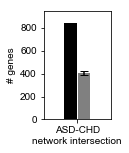

In [33]:
dpairlist=[('ASD','CHD')]

obs_temp_list = []
exp_temp_list=[]
exp_std_list = []
xlabel_list=[]
high_zrand_list = []
for dpair in dpairlist:
    d1=dpair[0]
    d2=dpair[1]
    z1=z_dict[d1]
    z2=z_dict[d2]
    # run the function again to get the distribution
#     z_d1d2_size,high_z_rand=calculate_expected_overlap(d1,d2,z1,z2,plot=False,numreps=100,zthresh=3)
#     high_zrand_list.append(high_z_rand)
    obs_temp_list.append(network_num_overlap.loc[d1][d2])
    exp_temp_list.append(network_exp_mean_overlap.loc[d1][d2])
    exp_std_list.append(network_exp_std_overlap.loc[d1][d2])
    xlabel_list.append(d1+'-'+d2)
    
    
plt.figure(figsize=(1.2,2))
plt.bar(np.arange(len(obs_temp_list))-.2,obs_temp_list,width=.38,color='black',label='observed')
plt.bar(np.arange(len(exp_temp_list))+.2,exp_temp_list,width=.38,color='gray',label='expected')
plt.errorbar(np.arange(len(exp_temp_list))+.2,exp_temp_list,exp_std_list,fmt='none',color='k',capsize=4)
# plt.violinplot(high_zrand_list,positions=np.arange(len(exp_temp_list))+.2)
plt.ylabel('# genes',fontsize=10)
plt.xticks(np.arange(len(obs_temp_list)),['ASD-CHD\nnetwork intersection'],fontsize=10,rotation='horizontal')
plt.yticks(fontsize=10)
plt.xlim([-1,1])
plt.ylim([0,950])
# plt.legend(loc='upper right',fontsize=11)
plt.savefig('../../../manuscript/figures_1911/Figure2/Figure2_final assets/num_net_intersection_genes_ASD_CHD.png',dpi=300,bbox_inches='tight')
plt.savefig('../../../manuscript/figures_1911/Figure2/Figure2_final assets/num_net_intersection_genes_ASD_CHD.svg',dpi=300,bbox_inches='tight')

In [64]:
network_exp_std_overlap

,psoriasis,atherosclerosis,kartagener,CHD,ASD,ASD_GWAS
psoriasis,1.000000,20.591306,13.828073,16.328245,18.040499,14.901929
atherosclerosis,20.591306,1.000000,16.585834,19.455704,19.802737,17.558687
kartagener,13.828073,16.585834,1.000000,12.828484,13.893437,11.982567
CHD,16.328245,19.455704,12.828484,1.000000,16.336129,15.176228
ASD,18.040499,19.802737,13.893437,16.336129,1.000000,17.900380
ASD_GWAS,14.901929,17.558687,11.982567,15.176228,17.900380,1.000000


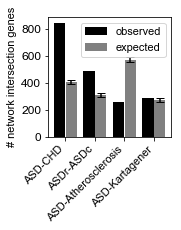

In [35]:
dpairlist=[('ASD','CHD'),('ASD','ASD_GWAS'),('ASD','atherosclerosis'),('ASD','kartagener')]

obs_temp_list = []
exp_temp_list=[]
exp_std_list = []
xlabel_list=[]
high_zrand_list = []
for dpair in dpairlist:
    d1=dpair[0]
    d2=dpair[1]
    z1=z_dict[d1]
    z2=z_dict[d2]
    # run the function again to get the distribution
#     z_d1d2_size,high_z_rand=calculate_expected_overlap(d1,d2,z1,z2,plot=False,numreps=100,zthresh=3)
#     high_zrand_list.append(high_z_rand)
    obs_temp_list.append(network_num_overlap.loc[d1][d2])
    exp_temp_list.append(network_exp_mean_overlap.loc[d1][d2])
    exp_std_list.append(network_exp_std_overlap.loc[d1][d2])
    xlabel_list.append(d1+'-'+d2)
    
    
plt.figure(figsize=(2.2,2.2))
plt.bar(np.arange(len(obs_temp_list))-.2,obs_temp_list,width=.38,color='black',label='observed')
plt.bar(np.arange(len(exp_temp_list))+.2,exp_temp_list,width=.38,color='gray',label='expected')
plt.errorbar(np.arange(len(exp_temp_list))+.2,exp_temp_list,exp_std_list,fmt='none',color='k',capsize=4)
# plt.violinplot(high_zrand_list,positions=np.arange(len(exp_temp_list))+.2)
plt.ylabel('# network intersection genes',fontsize=11)
plt.xticks(np.arange(len(obs_temp_list)),['ASD-CHD','ASDr-ASDc','ASD-Atherosclerosis','ASD-Kartagener'],fontsize=11,rotation=45,va='top',ha='right')
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=11)
# plt.savefig('../../../manuscript/figures_1911/Figure2/Figure2_final assets/num_net_intersection_genes.png',dpi=300,bbox_inches='tight')
# plt.savefig('../../../manuscript/figures_1911/Figure2/Figure2_final assets/num_net_intersection_genes.svg',dpi=300,bbox_inches='tight')

In [116]:
np.arange(len(exp_temp_list))+.2

array([0.2, 1.2, 2.2])

In [118]:
plt.violinplot(high_zrand_list,positions=np.arange(len(exp_temp_list))+.2)

TypeError: violinplot() got an unexpected keyword argument 'color'

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25]),
 <a list of 10 Text yticklabel objects>)

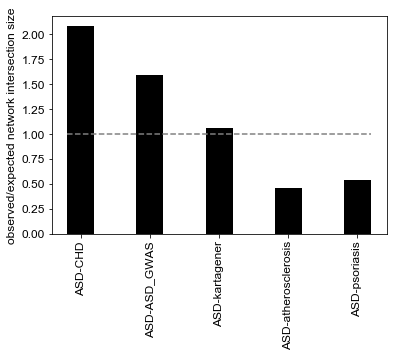

In [71]:
dpairlist=[('ASD','CHD'),('ASD','ASD_GWAS'),
          ('ASD','kartagener'),('ASD','atherosclerosis'),('ASD','psoriasis')]

obs_temp_list = []
obs_exp_temp_list = []
exp_temp_list=[]
exp_std_list = []
xlabel_list=[]
for dpair in dpairlist:
    d1=dpair[0]
    d2=dpair[1]
    obs_temp_list.append(network_num_overlap.loc[d1][d2])
    exp_temp_list.append(network_exp_mean_overlap.loc[d1][d2])
    exp_std_list.append(network_exp_std_overlap.loc[d1][d2])
    obs_exp_temp_list.append(network_obs_exp.loc[d1][d2])
    xlabel_list.append(d1+'-'+d2)
    
plt.bar(np.arange(len(obs_exp_temp_list)),obs_exp_temp_list,width=.39,color='black',label='observed')
plt.plot([-.2,len(obs_exp_temp_list)-.8],[1,1],'--',color='gray')
# plt.bar(np.arange(len(exp_temp_list))+.2,exp_temp_list,width=.39,color='gray',label='expected')
# plt.errorbar(np.arange(len(exp_temp_list))+.2,exp_temp_list,exp_std_list,fmt='.',color='k')
plt.ylabel('observed/expected network intersection size',fontsize=12)
plt.xticks(np.arange(len(obs_temp_list)),xlabel_list,fontsize=12,rotation='vertical')
plt.yticks(fontsize=12)

In [13]:

combined_edges = pd.DataFrame(columns = ['d1','d2',
                                        'num_shared_network','neg_logP_shared_network','edge_label','obs_exp'])


for i in np.arange(len(focal_diseases)-1):
    for j in np.arange(i+1,len(focal_diseases)):
        d1 = focal_diseases[i]
        d2 = focal_diseases[j]
        num_shared_network_temp = network_num_overlap.loc[d1][d2]
        pval_shared_network_temp = network_pval_overlap.loc[d1][d2]
        edge_label_temp = str(nsf(pval_shared_network_temp,2))
        obs_exp_temp = network_obs_exp.loc[d1][d2]
        
        df_temp = pd.DataFrame({'d1':[d1],'d2':[d2],
                               'num_shared_network':[num_shared_network_temp],
                               'neg_logP_shared_network':[-np.log(pval_shared_network_temp)],
                               'edge_label':[edge_label_temp],
                               'obs_exp':[obs_exp_temp]})
        combined_edges = combined_edges.append(df_temp,ignore_index=True)
        

# combined_edges.to_csv('disease_combined_edges_ATH_PSO_KART.tsv',sep='\t')
combined_edges
    

/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/Users/brinrosenthal/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,d1,d2,edge_label,neg_logP_shared_network,num_shared_network,obs_exp
0,psoriasis,atherosclerosis,0.0,inf,1535.0,2.847549
1,psoriasis,kartagener,1.0,-0.000000,110.0,0.429721
2,psoriasis,CHD,0.96,0.045115,353.0,0.927922
3,psoriasis,ASD,1.0,-0.000000,222.0,0.529454
4,atherosclerosis,kartagener,1.0,-0.000000,134.0,0.374574
5,atherosclerosis,CHD,0.076,2.579094,558.0,1.045845
6,atherosclerosis,ASD,1.0,-0.000000,257.0,0.450616
7,kartagener,CHD,1.0,0.000007,188.0,0.757210
8,kartagener,ASD,0.22,1.521685,290.0,1.042153
9,CHD,ASD,1.2e-162,372.859328,844.0,2.073710


array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

# Compare observed/expected genes at the ASD/CHD intersection as a function of zthresh

In [37]:
obs_exp_list = []
num_obs_list = []
zthresh_list = np.linspace(0,10,26)
for zthresh in zthresh_list:
    d1='ASD'
    d2='CHD'
    z1=z_dict[d1]
    z2=z_dict[d2]
    z_d1d2_size,high_z_rand=calculate_expected_overlap(d1,d2,z1,z2,plot=False,numreps=100,zthresh=zthresh)
    ztemp = (z_d1d2_size-np.mean(high_z_rand))/np.std(high_z_rand)
    ptemp = norm.sf(ztemp)
    obs_exp_temp = float(z_d1d2_size)/np.mean(high_z_rand)
    print(zthresh)
    print(ptemp)
    print(obs_exp_temp)
    
    obs_exp_list.append(obs_exp_temp)
    num_obs_list.append(z_d1d2_size)

0.0
5.066371108021597e-231
1.3307741141336258
0.4
4.013896750798385e-244
1.4612913255259612
0.8
5.678226330115399e-207
1.5755316305621612
1.2000000000000002
1.89286917251349e-254
1.6782559159425268
1.6
7.20284909451888e-136
1.7379035033381514
2.0
2.2744685122536853e-180
1.8412017789109243
2.4000000000000004
1.2460088572911168e-162
1.9392978155864753
2.8000000000000003
7.88730006920651e-145
2.0197993488804733
3.2
8.904099549451684e-140
2.1151141404305958
3.6
1.8891303649500069e-174
2.1982744372086875
4.0
2.7239089494848916e-86
2.2137283006848225
4.4
1.0895741967587442e-132
2.3179920334021213
4.800000000000001
2.693884526052619e-100
2.4068145437914477
5.2
1.0084982521852499e-79
2.443571476130235
5.6000000000000005
6.5848285256059665e-84
2.4942773699581657
6.0
1.5838396373588486e-75
2.5227497972790345
6.4
1.6398906463825887e-54
2.5159202421964713
6.800000000000001
4.6709011690835835e-46
2.488608482299334
7.2
1.5361082666423718e-50
2.4248045581025575
7.6000000000000005
4.537451974195217e-3

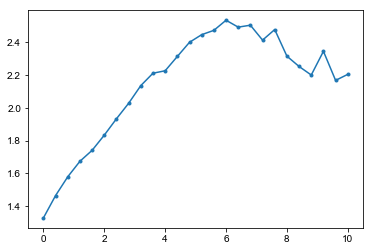

In [31]:
plt.plot(zthresh_list,obs_exp_list,'.-')


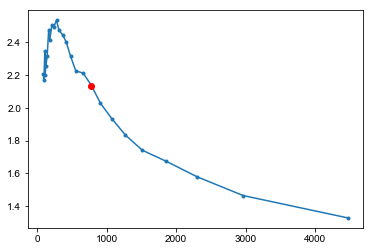

In [35]:
plt.plot(num_obs_list,obs_exp_list,'.-')
plt.plot(num_obs_list[8],obs_exp_list[8],'ro')

In [34]:
zthresh_list

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. ])